('This image is:', <type 'numpy.ndarray'>, 'with dimensions:', (480, 640, 3))


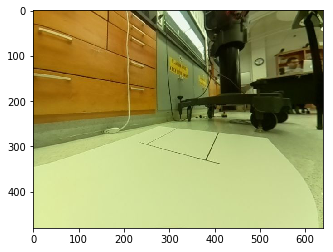

In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from __future__ import division
import copy
# reading in an image

image = mpimg.imread('parking_test_05.jpg')

# printing out some stats and plotting the image

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()



In [3]:
'''
add_contrast = copy.copy(image[:,:,1:3])
add_contrast = add_contrast*2
add_con_image = copy.copy(image)
add_con_image[:,:,1:3] = add_contrast

plt.imshow(add_con_image)
plt.show()
image = add_con_image
'''
find_cor = cv2.imread('parking_test_04.jpg')
cv2.imshow('find_coord',find_cor)
#cv2.waitKey(18000)
cv2.destroyAllWindows()

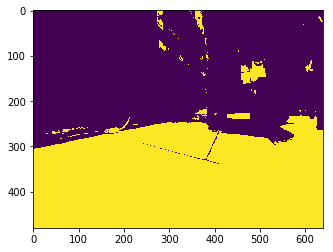

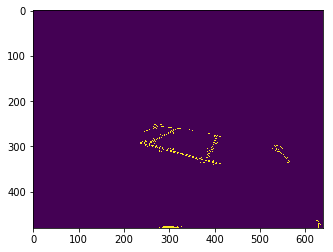

In [20]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    match_mask_color = 255 # This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



height = image.shape[0]
width = image.shape[1]

region_of_interest_vertices = [
    (0, height),
    #(0, 350),
    (200,300),
    (270,250),
    (550,300),
    (width,height),
    #(width,280),  
    #(width, 170),
    #(width, height),
]

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
lower_yellow = np.array([35,50,150])
upper_yellow = np.array([40,250,250])
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)


plt.figure()
plt.imshow(mask)
plt.show()

res = cv2.bitwise_and(image,image,mask=mask)

cannyed_image = cv2.Canny(res, 20, 35)

# Moved the cropping operation to the end of the pipeline.
cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32)
)

plt.figure()
plt.imshow(cropped_image)

plt.show()

In [52]:
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 100,
    threshold=80,
    lines=np.array([]),
    minLineLength=32,
    maxLineGap=10
)
print('hough lines detected, lines number:',lines.shape[0])

('hough lines detected, lines number:', 7)


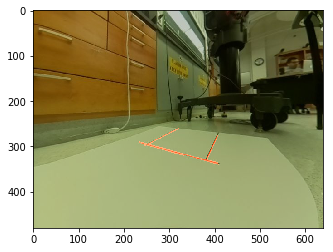

array([[[280, 302, 410, 339]],

       [[247, 298, 321, 260]],

       [[239, 293, 324, 317]],

       [[359, 324, 406, 335]],

       [[383, 328, 407, 276]],

       [[299, 308, 332, 319]],

       [[235, 290, 296, 307]]], dtype=int32)

In [53]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    # If there are no lines to draw, exit.
    if lines is None:
        return

    # Make a copy of the original image.
    img = np.copy(img)

    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )

    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)

    return img

line_image = draw_lines(image, lines) # <---- Add this call.

plt.figure()
plt.imshow(line_image)

plt.show()
lines

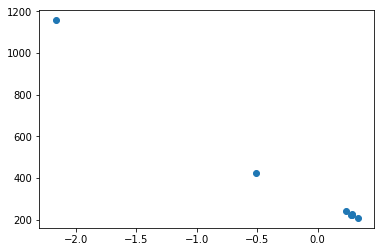

(7, 1, 4)

In [54]:
lines.shape
slope_list = list()
dev_list = list()
for line in lines:
    if (line[0][2]-line[0][0]) != 0:  # eliminate the lines with y1 = y2
        slope = (line[0][3]-line[0][1])/(line[0][2]-line[0][0])
        dev = line[0][1]-slope*line[0][0]
        slope_list.append(slope)
        dev_list.append(dev)

plt.figure()
plt.scatter(slope_list,dev_list)
plt.show()
lines.shape

In [55]:
from scipy.cluster.hierarchy import dendrogram, linkage
# some setting for this notebook to actually show the graphs inline
# you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [58]:


# combine slope and deviation in one list
lines_array = np.column_stack((slope_list, dev_list))


# filter can also be developed, like use (rou,theta) as data
lines_array_filted = copy.copy(lines_array)
def lines_array_filter(lines):
    for i in range(lines.shape[0]):
        
        if np.absolute(lines[i][0]) > 4:
           
            lines[i][0] = lines[i][0]/lines[i][0] * 4
            lines[i][1] = lines[i][1]/lines[i][1] * 1200
            

lines_array_filter(lines_array_filted)


Z = linkage(lines_array_filted, 'ward')

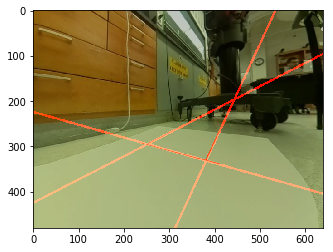

('The number of cluster is:', 3)


In [59]:
# a integreted function to use dendrogram_hierarchy clusters

# Note_here can write a loop to increase max_d until get 3 valid lines

from scipy.cluster.hierarchy import fcluster
max_d = image.shape[0]*0.3
clusters = fcluster(Z, max_d, criterion='distance')
cluster_number = np.unique(clusters).shape[0]

# define a function to calculate the ave k and b for each line
def lines_para_ave(clst_num, clsts):
    lineslope_array_cluster = np.zeros((clst_num, 1))
    slope_ave = np.zeros((cluster_number, 1))
    linedev_array_cluster = np.zeros((clst_num, 1))
    dev_ave = np.zeros((cluster_number, 1))


    for i in range (clst_num):
        count = 0
        for j in range (clsts.shape[0]):
            if clsts[j] == (i+1):
                count += 1
                lineslope_array_cluster[i][0] += lines_array[j][0]
                linedev_array_cluster[i][0] += lines_array[j][1]
        slope_ave[i][0] = lineslope_array_cluster[i][0]/count
        dev_ave[i][0] = linedev_array_cluster[i][0]/count
    return slope_ave, dev_ave

slope_ave, dev_ave = lines_para_ave(cluster_number,clusters)

# a function to draw new lines given the lines_para_ave
def draw_new_lines(k_ave, b_ave):
    new_lines = np.zeros((k_ave.shape[0],1,4))
    for i in range(b_ave.shape[0]):

        new_y2 = k_ave[i][0]*width + dev_ave[i][0]
        new_y2 = int(new_y2)
        b_ave[i][0] = int(b_ave[i][0])
        new_y1 = b_ave[i][0]
        temp_lines = np.zeros((1,4))
        temp_lines[0] = [0, new_y1, width, new_y2]
        new_lines[i] = temp_lines

    new_lines = new_lines.astype(int)
    new_lines_img = draw_lines(image, new_lines, color=[255, 0, 0], thickness=3)
    plt.figure()
    plt.imshow(new_lines_img)
    plt.show()
    return new_lines

new_lines = draw_new_lines(slope_ave, dev_ave)
print('The number of cluster is:', cluster_number)

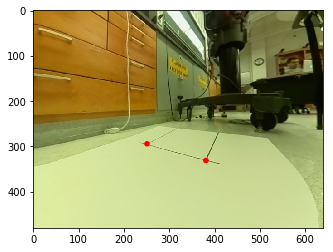

In [60]:

intersect_pts = list()
for i in range(new_lines.shape[0]):
    for j in range(i+1, new_lines.shape[0]):
               
        k1 = (new_lines[i][0][3] - new_lines[i][0][1])/(new_lines[i][0][2]-new_lines[i][0][0])
        
        k2 = (new_lines[j][0][3] - new_lines[j][0][1])/(new_lines[j][0][2]-new_lines[j][0][0])

        x = - (new_lines[j][0][1]-new_lines[i][0][1])/(k2-k1)
        y = k1*x + new_lines[i][0][1]
        
        temp = [x, y]
        
        intersect_pts.append(temp)
intersect_pts = np.array(intersect_pts)
intersect_pts = intersect_pts.astype(int)

# eliminate those invalid pts
def refine_intersect(intersect):
    refine = intersect
    for i in range(intersect.shape[0]):
        x = intersect[i][0]
        y = intersect[i][1]

        if (x<=0 or x>=600 or y<=228 or y>=480):
            refine = np.delete(intersect,i,0)
    return refine

intersect_pts = refine_intersect(intersect_pts)



from matplotlib.patches import Circle
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(image)


for x,y in intersect_pts:
    circ = Circle((x,y),5,color='r')
    ax.add_patch(circ)

plt.show()



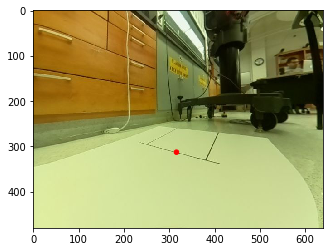

the pixel coordinate is : (316.0, 312.5)


In [61]:
# calculate the mid_point pixel location

def get_midpoint(intersect):
    mid_x = np.sum(intersect[:,0])/intersect.shape[0]
    mid_y = np.sum(intersect[:,1])/intersect.shape[0]
    return mid_x,mid_y


mid_x, mid_y = get_midpoint(intersect_pts)
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(image)


circ_mid = Circle((mid_x,mid_y),5,color='r')
ax.add_patch(circ_mid)

plt.show()
print('the pixel coordinate is : (%5.1f, %5.1f)'%(mid_x,mid_y))

In [35]:
line_array_cluster = np.zeros((2*cluster_number, clusters.shape[0]))
line_array_cluster.shape

(6, 7)

In [36]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(lines_array))
c

0.9943080533474893

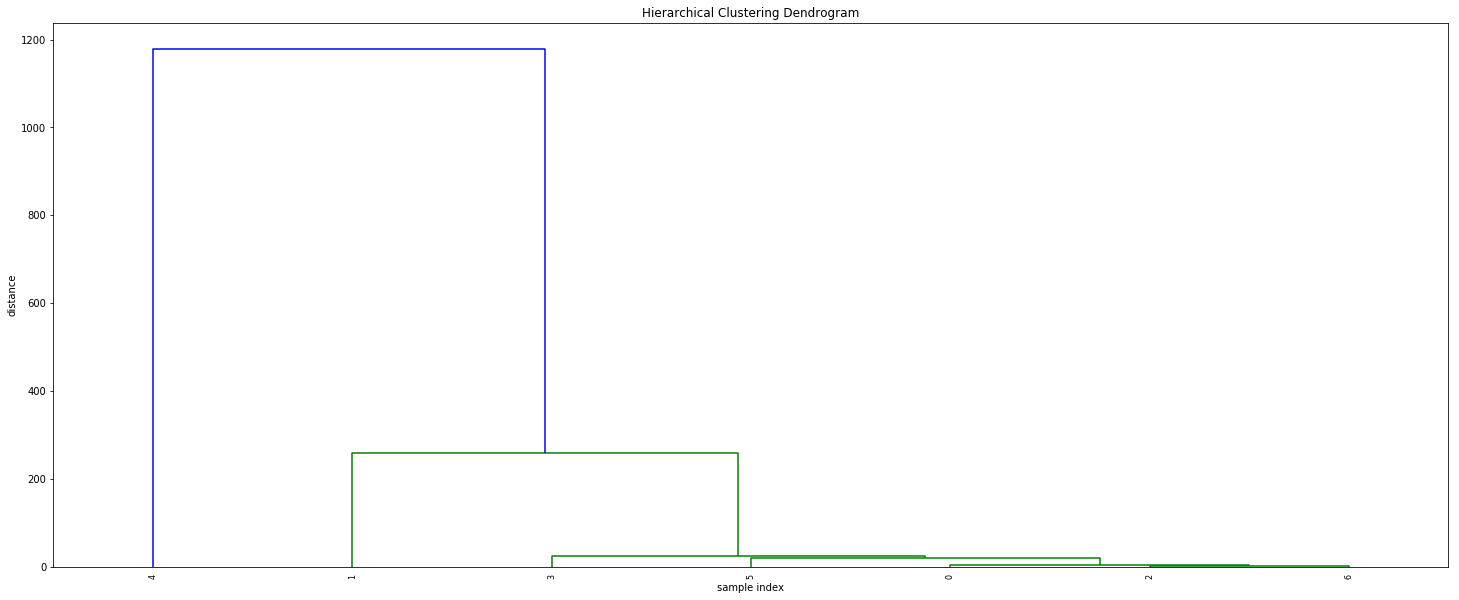

In [37]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()



In [149]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

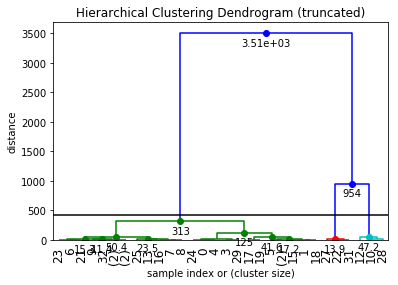

In [152]:
# define max_distance
max_d = 420

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    #p=12, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [154]:


from scipy.cluster.hierarchy import fcluster
max_d = 420
clusters = fcluster(Z, max_d, criterion='distance')
clusters



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1], dtype=int32)

In [56]:

left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        print(slope)
        if math.fabs(slope) < 0.5: 
            #print(math.fabs(slope))
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

min_y = int(image.shape[0] * (2 / 5)) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image

poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))

left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))

poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))

right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

2.7228915662650603
-0.32
-0.3300970873786408
-0.31343283582089554
-0.3333333333333333
-0.2692307692307692
-0.3076923076923077
-0.319672131147541
-0.26666666666666666
-0.3508771929824561
-0.35294117647058826
-0.3508771929824561
2.3333333333333335
-0.2923076923076923
-0.36666666666666664
-0.39344262295081966
2.7586206896551726
-0.31016042780748665
-0.3157894736842105
-0.42592592592592593
-0.35294117647058826
2.892857142857143
-0.3
-0.3076923076923077
-0.36363636363636365
2.473684210526316
-0.3333333333333333
2.8636363636363638
-0.36363636363636365
-0.3815789473684211
2.923076923076923
3.0
-0.3
-0.34285714285714286
-0.3157894736842105
-0.30434782608695654
-0.4166666666666667
-0.3333333333333333
-0.3469387755102041
-0.3111111111111111
-0.42857142857142855
-0.3783783783783784
-0.36486486486486486
-0.4444444444444444
1.5862068965517242
-0.34210526315789475
-0.323943661971831
3.125
-0.36363636363636365
-0.32432432432432434
-0.35714285714285715
2.0
2.7142857142857144
-0.3333333333333333
3.0
-0

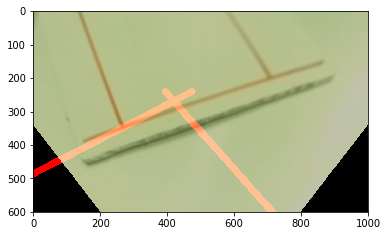

In [57]:

line_image = draw_lines(
    image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=20)

plt.figure()
plt.imshow(line_image)

plt.show()

600

IndexError: index 600 is out of bounds for axis 0 with size 600